# Finding Heavy Traffic Indicators on I-94

In this project, we are going to analyze a dataset about the westbound traffic on the [ I-94 Interstate highway](https://en.wikipedia.org/wiki/Interstate_94).

The goal of our analysis is to determine a few indicators of heavy traffic on I-94. These indicators can be weather type, time of the day, time of the week, etc.

## The I-94 Traffic Dataset

John Hogue made the dataset available, and you can download it from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume).


In [1]:
import pandas as pd

i_94 = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

i_94.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [2]:
i_94.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [3]:
i_94.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


The dataset has 48,204 rows and 9 columns, and there are no null values. Each row describes traffic and weather data for a specific hour — we have data from 2012-10-02 09:00:00 until 2018-09-30 23:00:00.

The [documentation](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume) provides a description of each column.

- `holiday` - Categorical US National holidays plus regional holiday, Minnesota State Fair
- `temp` - Numeric Average temp in kelvin
- `rain_1h` - Numeric Amount in mm of rain that occurred in the hour
- `snow_1h` - Numeric Amount in mm of snow that occurred in the hour
- `clouds_all` - Numeric Percentage of cloud cover
- `weather_main` - Categorical Short textual description of the current weather
- `weather_description` - Categorical Longer textual description of the current weather
- `date_time` - DateTime Hour of the data collected in local CST time
- `traffic_volume` - Numeric Hourly I-94 ATR 301 reported westbound traffic volume

A station located approximately midway between Minneapolis and Saint Paul records the traffic data. For this station, the direction of the route is westbound (i.e., cars moving from east to west). 

![img](https://s3.amazonaws.com/dq-content/524/i94_figma.png)

This means that the results of our analysis will be about the westbound traffic in the proximity of the station. In other words, we should avoid generalizing our results for the entire I-94 highway.

## Analyzing Traffic Volume

We are going to start our analysis by examining the distribution of the `traffic_volume` column.


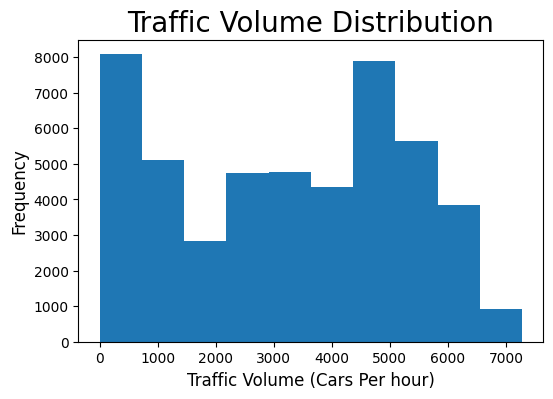

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(i_94['traffic_volume'])
plt.title('Traffic Volume Distribution', fontsize=20)
plt.xlabel('Traffic Volume (Cars Per hour)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [5]:
i_94['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

- Between 2012-10-02 09:00:00 and 2018-09-30 23:00:00, the hourly traffic volume varied from 0 to 7,280 cars, with an average of 3,260 cars.

- About 25% of the time, there were 1,193 cars or fewer passing the station each hour — this probably occurs during the night, or when a road is under construction. 

- About 25% of the time, the traffic volume was four times as much (4,933 cars or more).

This possibility that nighttime and daytime might influence traffic volume gives our analysis an interesting direction: comparing daytime with nighttime data.

## Traffic Volume: Day vs. Night

We will start by dividing the dataset into two parts:

- Daytime data: hours from 7 a.m. to 7 p.m. (12 hours)
- Nighttime data: hours from 7 p.m. to 7 a.m. (12 hours)

While this is not a perfect criterion for distinguishing between nighttime and daytime, it's a good starting point.


In [6]:
i_94['date_time'] = pd.to_datetime(i_94['date_time'])

day = i_94.copy()[(i_94['date_time'].dt.hour >= 7) & (i_94['date_time'].dt.hour < 19)]
print('Day:', day.shape[0])

night = i_94.copy()[(i_94['date_time'].dt.hour < 7) | (i_94['date_time'].dt.hour >= 19)]
print('Night:', night.shape[0])


Day: 23877
Night: 24327


This significant difference in row numbers between `day` and `night` is due to a few hours of missing data. For instance, if you look at rows 176 and 177 (`i_94.iloc[176:178]`), you will notice there is no data for two hours (`4` and `5`).


In [7]:
i_94.iloc[176:178]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
176,None,281.17,0.0,0.0,90,Clouds,overcast clouds,2012-10-10 03:00:00,361
177,None,281.25,0.0,0.0,92,Clear,sky is clear,2012-10-10 06:00:00,5875


Now we are going to compare the traffic volume at night and during day.


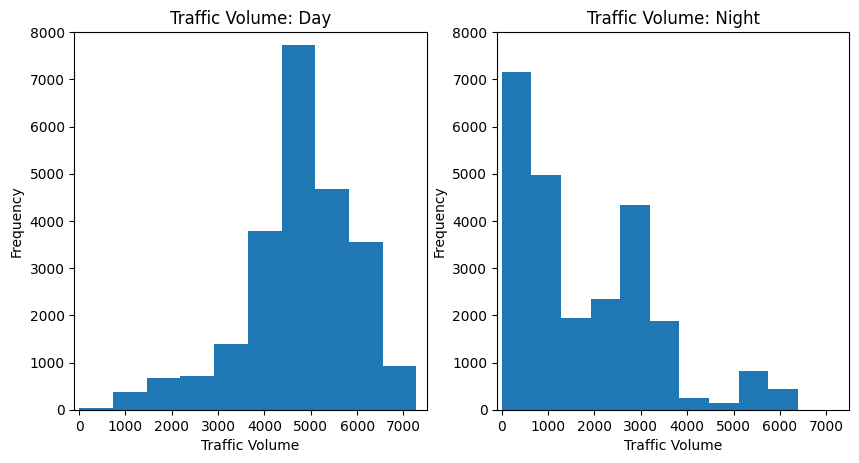

In [8]:
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.hist(day['traffic_volume'])
plt.title('Traffic Volume: Day')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.xlim(-100, 7500)
plt.ylim(0, 8000)


plt.subplot(1, 2, 2)
plt.hist(night['traffic_volume'])
plt.title('Traffic Volume: Night')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.xlim(-100, 7500)
plt.ylim(0, 8000)

plt.show()


In [9]:
print('Day Time info:')
print(round(day['traffic_volume'].describe()))
print('')
print('Night Time info:')
print(round(night['traffic_volume'].describe()))

Day Time info:
count    23877.0
mean      4762.0
std       1175.0
min          0.0
25%       4252.0
50%       4820.0
75%       5559.0
max       7280.0
Name: traffic_volume, dtype: float64

Night Time info:
count    24327.0
mean      1785.0
std       1442.0
min          0.0
25%        530.0
50%       1287.0
75%       2819.0
max       6386.0
Name: traffic_volume, dtype: float64


*Daytime*:

- The histogram that shows the distribution of traffic volume during the day is left skewed. 

- Most of the traffic volume values are high — there are 4,252 or more cars passing the station each hour 75% of the time.

- The majority of traffic volume values lie between 4000 and 6000 cars per hour, with an average of 4,762 cars per hour.

*Nighttime*

- The histogram displaying the nighttime data is right skewed. 

- Most of the traffic volume values are low — 75% of the time, the number of cars that passed the station each hour was less than 2,819.

Although there are still measurements of over 5,000 cars per hour, the traffic at night is generally light. Our goal is to find indicators of heavy traffic, so we'll only focus on the daytime data moving forward.


## Time Indicators - Part One

One of the possible indicators of heavy traffic is time. There might be more people on the road in a certain month, on a certain day, or at a certain time of the day.

We're going to look at a few line plots showing how the traffic volume changed according to the following parameters:

- Month
- Day of the week
- Time of day


In [10]:
day['month'] = day['date_time'].dt.month
by_month = day.groupby('month').mean()
by_month['traffic_volume']

month
1     4495.613727
2     4711.198394
3     4889.409560
4     4906.894305
5     4911.121609
6     4898.019566
7     4595.035744
8     4928.302035
9     4870.783145
10    4921.234922
11    4704.094319
12    4374.834566
Name: traffic_volume, dtype: float64

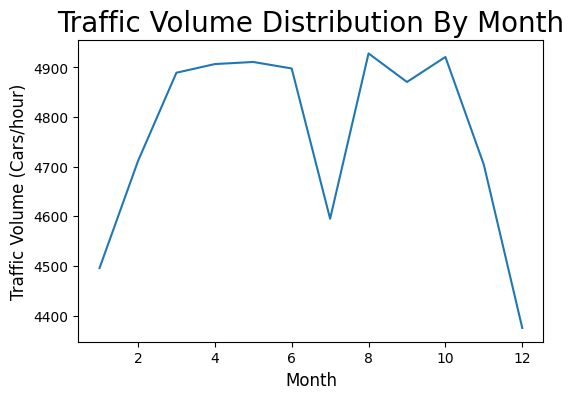

In [11]:
plt.plot(by_month['traffic_volume'])
plt.title('Traffic Volume Distribution By Month', fontsize=20)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Traffic Volume (Cars/hour)', fontsize=12)
plt.show()

Traffic appears to be less heavy during the cooler months (November–February) and more intense during the warmer months (March–October). With one notable exception: July. Is July unique? Is traffic generally less congested in July than in other months?

Let's look at how traffic volume varied in July each year to address the last question.

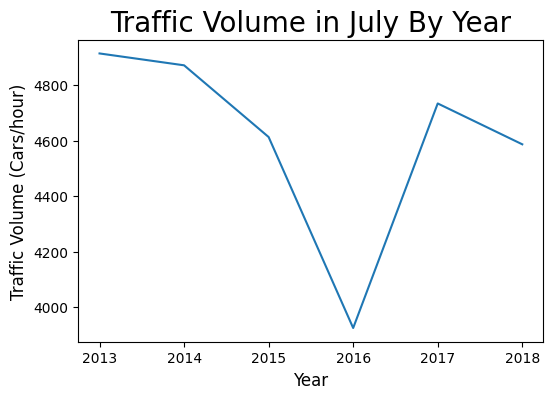

In [12]:
day['year'] = day['date_time'].dt.year
only_july = day[day['month'] == 7]

only_july.groupby('year').mean()['traffic_volume'].plot.line()
plt.title('Traffic Volume in July By Year', fontsize=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Traffic Volume (Cars/hour)', fontsize=12)
plt.show()

In July, as in the other warm months, traffic is usually quite busy. The only year in which we detect a decrease in traffic volume is 2016. One likely explanation is road construction, which is supported by [this story from 2016](https://www.crainsdetroit.com/article/20160728/NEWS/160729841/weekend-construction-i-96-us-23-bridge-work-i-94-lane-closures-i-696).

As a rough estimate, we can claim that warm months have more traffic than cold months. During a hot month, you may expect a traffic level of around 5,000 cars per hour during the day.


## Time Indicators - Part Two

We will now continue with building line plots for another time unit: day of the week.

In [13]:
day['dayofweek'] = day['date_time'].dt.dayofweek
by_dayofweek = day.groupby('dayofweek').mean()
by_dayofweek['traffic_volume']  # 0 is Monday, 6 is Sunday

dayofweek
0    4893.551286
1    5189.004782
2    5284.454282
3    5311.303730
4    5291.600829
5    3927.249558
6    3436.541789
Name: traffic_volume, dtype: float64

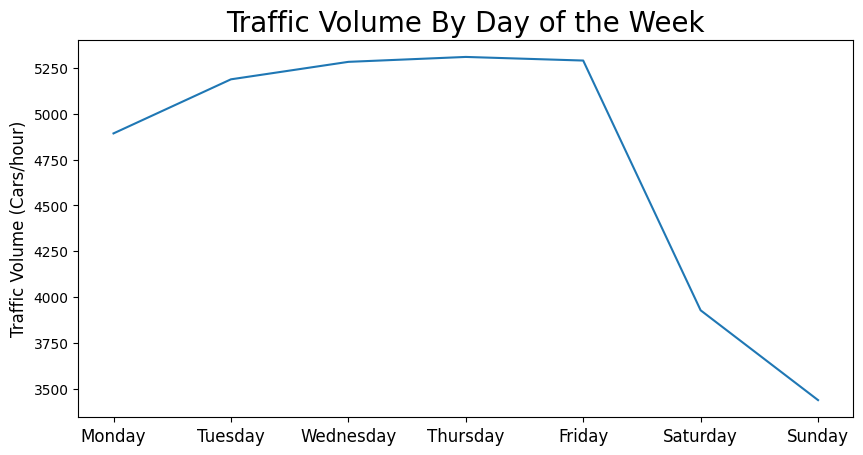

In [14]:
plt.figure(figsize=(10,5))
by_dayofweek['traffic_volume'].plot.line()
plt.title('Traffic Volume By Day of the Week', fontsize=20)
plt.xlabel(xlabel=None)
plt.ylabel('Traffic Volume (Cars/hour)', fontsize=12)

days_of_weeks_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
xticks=[i for i in range(0, 6+1)]
plt.xticks(ticks=xticks, labels=days_of_weeks_list, fontsize=12)

plt.show()

On business days (Monday – Friday), traffic volume is much higher. During the week, we observe numbers over 5,000, except on Monday. Weekend traffic is lighter, with levels below 4,000 cars.

## Time Indicators - Part Three

Let's take a look at the values we have based on the time of day. Weekends, on the other hand, will lower the average values, therefore we will just look at the averages separately.

In [15]:
day['hour'] = day['date_time'].dt.hour

bussiness_days = day.copy()[day['dayofweek'] <= 4] # 4 == Friday
weekend = day.copy()[day['dayofweek'] >= 5] # 5 == Saturday

by_hour_business = bussiness_days.groupby('hour').mean()
by_hour_weekend = weekend.groupby('hour').mean()

print('By hour during business day:')
print(by_hour_business['traffic_volume'])
print('')
print('By hour during weekend:')
print(by_hour_weekend['traffic_volume'])

By hour during business day:
hour
7     6030.413559
8     5503.497970
9     4895.269257
10    4378.419118
11    4633.419470
12    4855.382143
13    4859.180473
14    5152.995778
15    5592.897768
16    6189.473647
17    5784.827133
18    4434.209431
Name: traffic_volume, dtype: float64

By hour during weekend:
hour
7     1589.365894
8     2338.578073
9     3111.623917
10    3686.632302
11    4044.154955
12    4372.482883
13    4362.296564
14    4358.543796
15    4342.456881
16    4339.693805
17    4151.919929
18    3811.792279
Name: traffic_volume, dtype: float64


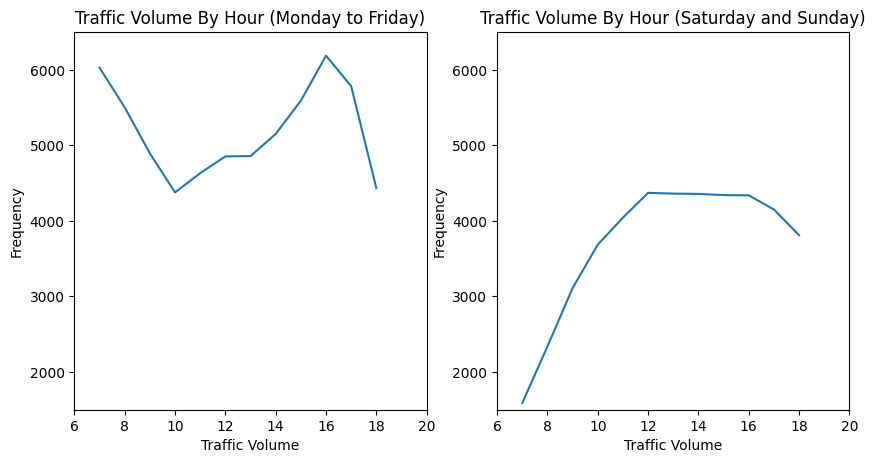

In [16]:
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(by_hour_business['traffic_volume'])
plt.title('Traffic Volume By Hour (Monday to Friday)')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.xlim(6, 20)
plt.ylim(1500, 6500)


plt.subplot(1, 2, 2)
plt.plot(by_hour_weekend['traffic_volume'])
plt.title('Traffic Volume By Hour (Saturday and Sunday)')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.xlim(6, 20)
plt.ylim(1500, 6500)

plt.show()

During business days, traffic volume is often higher than on weekends. The peak hours, as expected, are between 7 a.m. and 4 p.m., when the majority of people go from home to work and return. During rush hour, we see over 6,000 cars.

To summarise, we discovered a few traffic-related time indicators:

- During the warm months (March–October), traffic is usually heavier than during the cold months (November–February).

- On weekdays, traffic is typically heavier than on weekends.
On business days, rush hours are around 7 a.m. and 4 p.m.


## Weather Indicators

Another possible indicator of heavy traffic is weather. The dataset provides us with a few useful columns about weather: `temp`, `rain_1h`, `snow_1h`, `clouds_all`, `weather_main`, and `weather_description`.

A few of these columns are numerical so let's start by looking up their correlation values with `traffic_volume`.


In [17]:
#day.corr()['traffic_volume']


corr_traffic_temp = day['traffic_volume'].corr(day['temp'])
corr_traffic_rain = day['traffic_volume'].corr(day['rain_1h'])
corr_traffic_snow = day['traffic_volume'].corr(day['snow_1h'])
corr_traffic_clouds = day['traffic_volume'].corr(day['clouds_all'])

print('The correlation of traffic volume with:')
print('')
print('temperature ', round(corr_traffic_temp,5))
print('rain        ', round(corr_traffic_rain,5))
print('snow        ', round(corr_traffic_snow,5))
print('clouds     ', round(corr_traffic_clouds,5))

The correlation of traffic volume with:

temperature  0.12832
rain         0.0037
snow         0.00127
clouds      -0.03293


`Temperature` has the strongest correlation (+0.13). The other relevant columns (`rain 1h`, `snow 1h`, `clouds all`) show no significant link with traffic value.

Let's generate a scatter plot to visualize the correlation between `temperature` and `traffic_volume`.

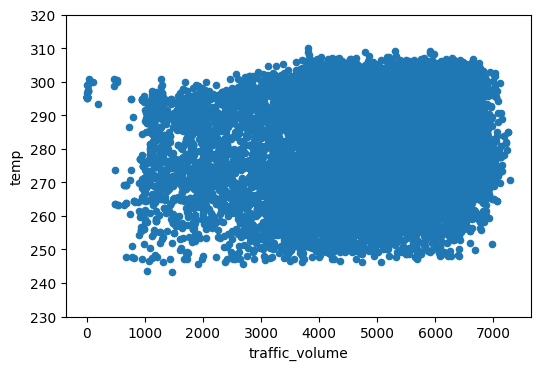

In [18]:
day.plot.scatter('traffic_volume', 'temp')
plt.ylim(230, 320) # two wrong 0K temperatures mess up the y-axis
plt.show()

We can conclude that `temperature` doesn't look like a solid indicator of heavy traffic.

Let's now look at the other weather-related columns: `weather_main` and `weather_description`.

## Weather Types

To start, we're going to group the data by `weather_main` and look at the `traffic_volume` averages.

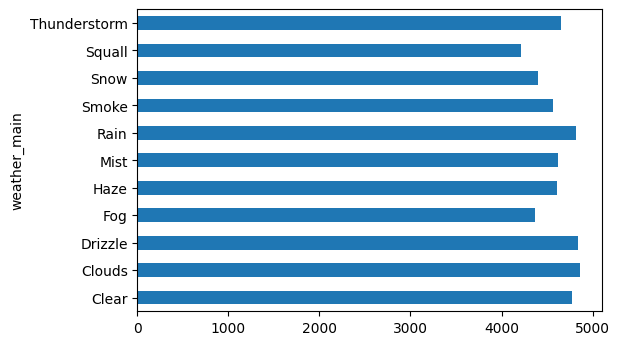

In [20]:
by_weather_main = day.groupby('weather_main').mean()
by_weather_main['traffic_volume'].plot.barh()
plt.show()

There appears to be no weather condition when traffic volume exceeds `5,000 cars`. This makes it more difficult to locate a high traffic indication. We can also group by `weather description`, which provides a more detailed weather classification.

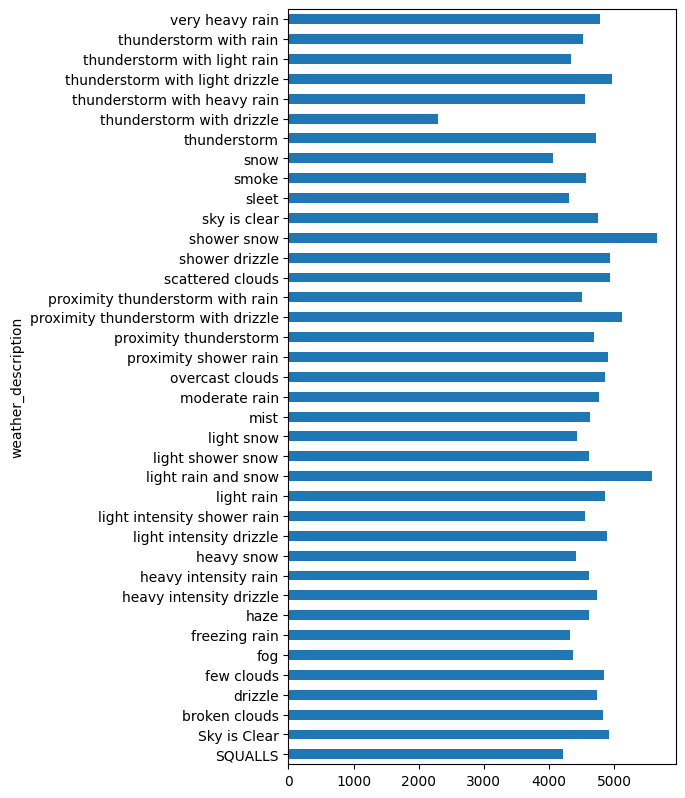

In [21]:
by_weather_description = day.groupby('weather_description').mean()
by_weather_description['traffic_volume'].plot.barh(figsize=(5,10))
plt.show()

There appear to be three weather conditions where traffic volume exceeds 5,000:

- Shower snow
- Light rain and snow
- Proximity thunderstorm with drizzle

It's unclear why these weather conditions have the highest average traffic figures – it's bad weather, but not very bad. When the weather is terrible, perhaps more people drive their cars instead of riding their bikes or walking.

## Conclusion

We tried to uncover a few indicators of heavy traffic on the I-94 Interstate highway in this research. We discovered two sorts of indicators:

- Time indicators
    - The summer months (March–October) see more traffic than the winter months (November–February).
    - On business days, traffic is typically heavier than on weekends.
    - On business days, rush hour is between 7 a.m and 4 p.m.

- Weather indicators
    - Shower snow
    - Light rain and snow
    - Proximity thunderstorm with drizzle